In [1]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from sklearn.metrics import accuracy_score
import pandas as pd
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:

def get_crop_loc(video):
    if video.get(3)==1920:
        return [0.12,0.35,0.08]
    elif video.get(3)==1280:
        return [0.05,0.25,0.1]

def get_by_frame(video,index):
    video.set(1,index)
    _,frame=video.read()
    video.set(1,0)
    return frame

def get_by_sec(video,sec):
    fps=video.get(5)
    video.set(1,int(fps*sec))
    _,frame=video.read()
    video.set(1,0)
    return frame

def get_key_part(frame):
    h,w=frame.shape[:2]
    return frame[int(crop_loc[0]*h):int(crop_loc[1]*h),int(w*(1/2-crop_loc[2])):int(w*(1/2+crop_loc[2]))]
    
def display_frame(video,index):
    frame=get_by_frame(video,index)
    figure(figsize=(15,12))
    imshow(frame)
    axis("off")
    show()

def display_frame_key(video,index):
    frame=get_by_frame(video,index)
    figure(figsize=(15,12))
    imshow(get_key_part(frame))
    axis("off")
    show()
    
def resize_key_frame(frame,size=(200,180)):
    return np.array(Image.fromarray(frame).resize(size))

def process_video(video):
    fps=video.get(5)
    total=video.get(7)
    frames=[]
    for i in range(int(total/fps)):
        frames.append(get_key_part(get_by_frame(video,i*fps)))
    return np.array(frames)

def preprocess(x,y):
    return Tensor(np.transpose(x,[0,3,1,2])).to("cuda:0"),Tensor(y).long().to("cuda:0")

def predict(x):
    batch_size=32
    with torch.no_grad():
        prediction=[]
        for i in range(0,len(x),batch_size):
            tx,ty=preprocess(x[i:i+batch_size],[])
            pred=model(tx)
            prediction+=list(pred.argmax(1).cpu().numpy())
    torch.cuda.empty_cache()
    return prediction   



In [3]:
def transfer_anno(path,sep=","):
    txt=open(path).read()
    time,label=txt.strip().split("\n")
    
    time=time.split(sep)
    time=[int(i) for i in time]
    
    label=label.split(sep)
    
    label=[""]+[int(i) for i in label[1:]]
    
    return time,label



    

# video_file="training_video/epic15.mp4"
# anno_file="anno/epic15.csv"
# video=cv2.VideoCapture(video_file)
# time,label=transfer_anno(anno_file,"\t")

In [4]:
videos=["training_video/"+i for i in os.listdir("training_video") if "epic" in i and i.endswith("mp4")]
annos=["anno/"+i.split("/")[1].split(".")[0]+".csv" for i in videos]

print(videos)
print(annos)

['training_video/epic0.mp4', 'training_video/epic1.mp4', 'training_video/epic10.mp4', 'training_video/epic11.mp4', 'training_video/epic12.mp4', 'training_video/epic13.mp4', 'training_video/epic14.mp4', 'training_video/epic15.mp4', 'training_video/epic16.mp4', 'training_video/epic2.mp4', 'training_video/epic5.mp4', 'training_video/epic7.mp4', 'training_video/epic8.mp4', 'training_video/epic9.mp4']
['anno/epic0.csv', 'anno/epic1.csv', 'anno/epic10.csv', 'anno/epic11.csv', 'anno/epic12.csv', 'anno/epic13.csv', 'anno/epic14.csv', 'anno/epic15.csv', 'anno/epic16.csv', 'anno/epic2.csv', 'anno/epic5.csv', 'anno/epic7.csv', 'anno/epic8.csv', 'anno/epic9.csv']


In [5]:
for i in range(len(videos)):
    print(i,"   ",videos[i])

0     training_video/epic0.mp4
1     training_video/epic1.mp4
2     training_video/epic10.mp4
3     training_video/epic11.mp4
4     training_video/epic12.mp4
5     training_video/epic13.mp4
6     training_video/epic14.mp4
7     training_video/epic15.mp4
8     training_video/epic16.mp4
9     training_video/epic2.mp4
10     training_video/epic5.mp4
11     training_video/epic7.mp4
12     training_video/epic8.mp4
13     training_video/epic9.mp4


In [7]:


def process_video_anno(video,time,label,name):
    x=[]
    y=[]
    for i in range(1,len(label)):
        print(time[i]-time[i-1],end="   ")
        if label[i]==0:
            for j in range(time[i-1],time[i],20):
                x.append(get_key_part(get_by_frame(video,j)))
                y.append(0)
                print(round(j/time[i],3),end="\r")
        elif label[i]==1:
            for j in range(time[i-1],time[i],20):
                x.append(get_key_part(get_by_frame(video,j)))
                y.append(0)
        elif label[i]==2:
            for j in range(time[i-1],time[i]):
                x.append(get_key_part(get_by_frame(video,j)))
                y.append(1)
        else:
            print("wrong label:",label[i])
            break
        
        print("done...",round((i+1)/len(label),2))

    x=np.array(x)
    y=np.array(y)
    print(x.shape,y.shape)
    np.save("data/"+name+"_x",x)
    np.save("data/"+name+"_y",y)
    print("saved to data/"+name)
    return x,y

i=8
video=cv2.VideoCapture(videos[i])
time,label=transfer_anno(annos[i])
crop_loc=get_crop_loc(video)
x,y=process_video_anno(video,time,label,videos[i].split("/")[1].split(".")[0])
print(videos[i],"done.")


KeyboardInterrupt: 

In [6]:
video=cv2.VideoCapture(videos[i])
time,label=transfer_anno(annos[i])
x,y=process_video_anno(video,time,label,videos[i].split("/")[1].split(".")[0])
print(videos[i],"done.")

NameError: name 'process_video_anno' is not defined

In [165]:
for i in range(len(y)):
    if y[i]==1:
        imshow(x[i])
        
        break

In [10]:
video=cv2.VideoCapture(videos[i])
fps=video.get(5)

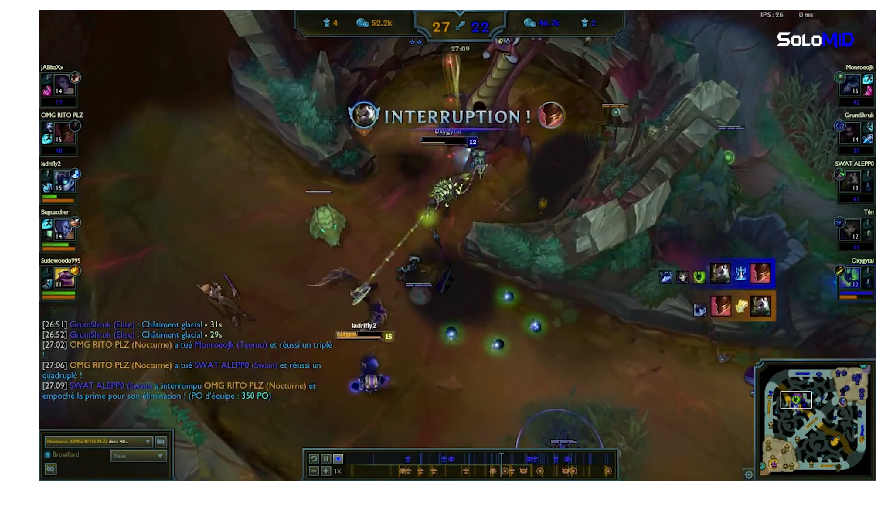

In [15]:
display_frame(video,int(fps*40))

In [48]:
t=open("training_video/CHALLENGER   MASTER TIER MONTAGE   League of Legends.csv").read().strip()
t

'0,22.57,50.28,59.2,1.11.45,1.21.31,1.31.55,1.40.27,1.51.4,1.58.23,2.18.35,2.27.12,2.31.8,2.40.20,3.2.25,3.12.0,3.14.50,3.31.42,3.37.29,3.45.54,4.13.12,4.19.40,4.33.26,4.38.43,4.42.52,4.55.11,5.15.24,5.28.19,5.36.11,5.49.1,5.56.36,5.58.43,6.22.13,6.41.3,6.56.11,7.3.41,7.5.22,7.21.20,7.33.20,7.39.30,7.42.24,7.55.5,8.1.58,8.19.8,8.29.50,8.32.18,8.46.23,8.53.11,9.6.44,9.15.54,9.18.56,9.25.32,9.47.56,10.5.34\n,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0'

In [56]:
video.get(5)

59.94170741967386

In [13]:
def time_transfor(s):
    if s=="0":
        return 0
    if s.count(".")==1:
        return int(float(s)*fps)
    else:
        l=s.split(".")
        return round((int(l[0])*60+float(".".join(l[1:3])))*fps)

        
time_transfor("9.25.32")

33886

In [60]:
round(3.9)

4

In [49]:
time,label=t.split("\n")

In [51]:
time=time.split(",")
len(time)

54

In [55]:
label=[int(i) for i in label.split(",")]
len(label)

AttributeError: 'list' object has no attribute 'split'

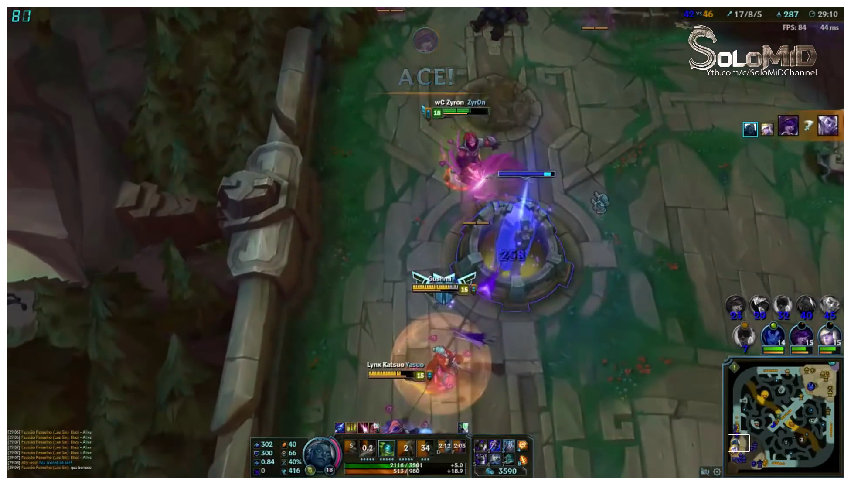

In [76]:
display_frame(video,time_transfor(time[2]))

In [82]:
for i in range(1,20):
    break
    if label[i]=="1":
        start=time_transfor(time[i-1])
        end=time_transfor(time[i])
        print(start,end,end-start)
        for j in range(start,end,50):
            display_frame(video,j)


In [77]:
time[2]

'50.28'

In [3]:

def transder_anno(path):
    txt=open(path).read()
    time,label=txt.strip().split("\n")
    
    time=time.split(",")
    time=[int(i) for i in time]
    
    label=label.split(",")
    
    label=[""]+[int(i) for i in label[1:]]
    
    print(len(label),len(time))
    return time,label

video=cv2.VideoCapture("training_video/CAN'T YOU STOP A GODLIKE - Best BALANCE Team Compilation #9 (League of Legends).mp4")

time,label=transder_anno("anno/can't anno.csv")


64 64


In [131]:
def transfer_anno(path,sep="\n"):
    txt=open(path).read()
    time,label=txt.strip().split("\n")
    
    time=time.split(sep)
    time=[int(i) for i in time]
    
    label=label.split(sep)
    
    label=[""]+[int(i) for i in label[1:]]
    
    print(len(label),len(time))
    return time,label


video_file="training_video/epic15.mp4"
anno_file="anno/epic15.csv"
video=cv2.VideoCapture(video_file)
time,label=transfer_anno(anno_file,"\t")

44 44


In [137]:

def modify(path,inc):
    open(path,"w").write(",".join([str(i+inc) for i in time])+"\n"+",".join([str(i) for i in label]))
    print("done.")

def to_30fps(path):
    open(path,"w").write(",".join([str(round(i/2)) for i in time])+"\n"+",".join([str(i) for i in label]))
    print("done.")
# modify(anno_file,2)
# to_30fps("anno/epic5.csv")

done.


In [104]:
print(time)
print(label)




[0, 1158, 1251, 2589, 2806, 4238, 4361, 6079, 6239, 7401, 7559, 9529, 9702, 11329, 11478, 13219, 13396, 14254, 14351, 16783, 17018, 18213, 18253, 20155, 20313, 23027, 23132, 25075, 25303, 27373, 27757, 31799, 32024, 33526, 33681, 35703, 35722, 36950]
['', 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0]


2685 2685


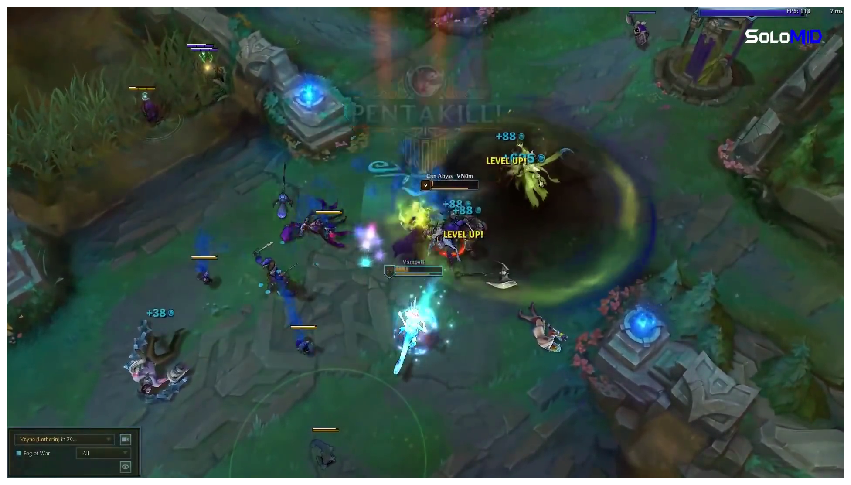

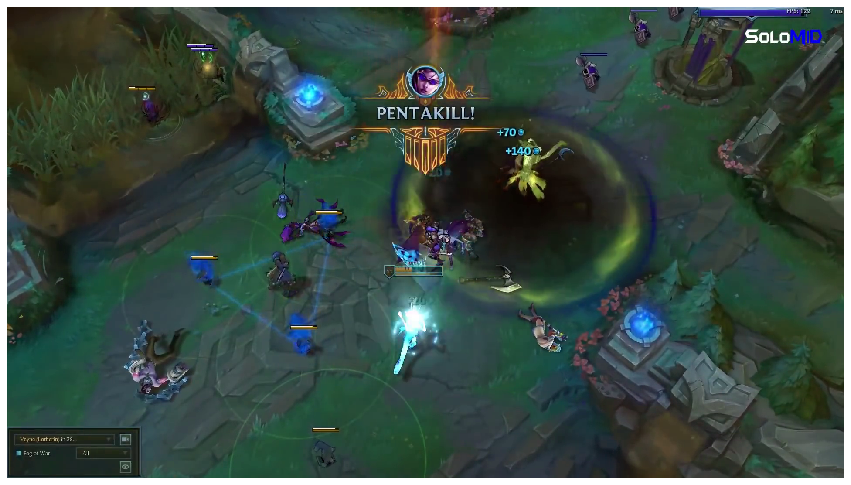

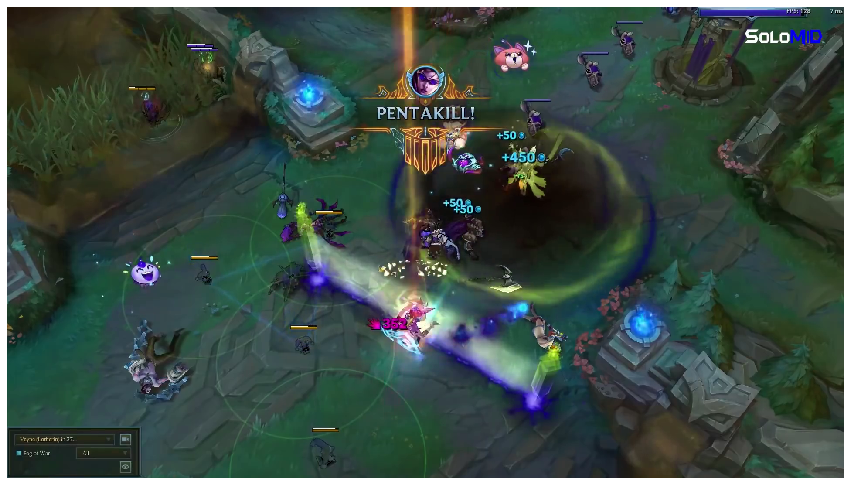

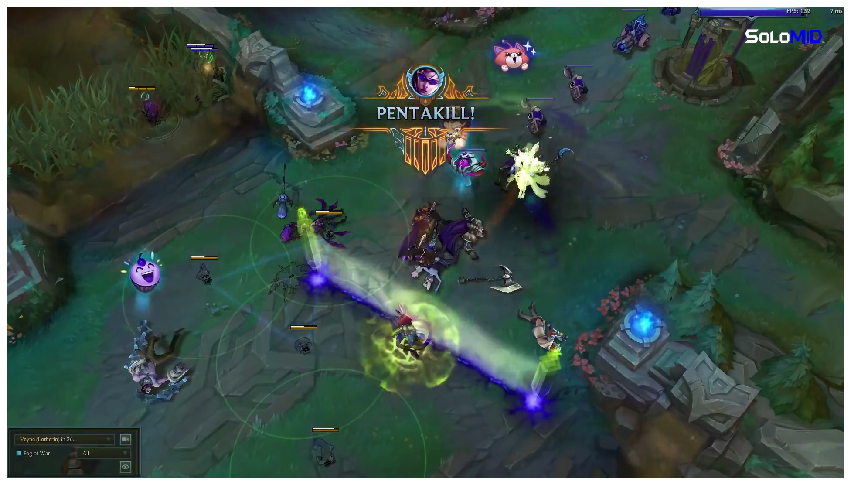

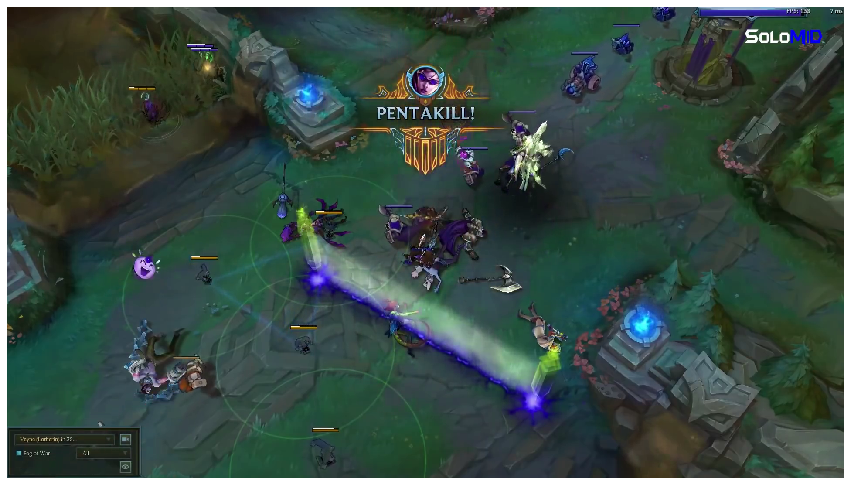

In [42]:
for i in range(len(label)):
    if label[i]==2:
        start=time[i-1]
        end=time[i]
        print(time[i-1],start)
        for j in range(start,end,50):
            display_frame(video,j)
        break

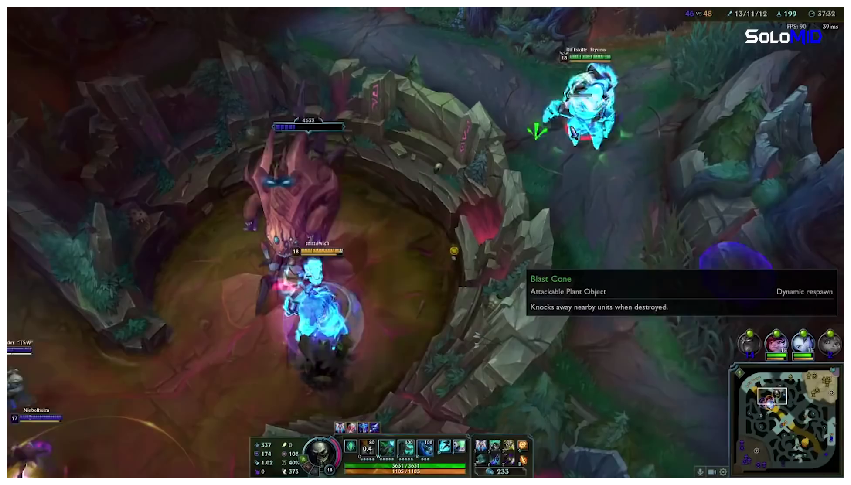

In [136]:
display_frame(video,31380+3)

In [31]:
video.get(7)

18184.0